In [1]:
import os
from pathlib import Path

# Print the current working directory
starting_path = os.getcwd()

# Change directory to sleap-roots
if os.path.basename(os.getcwd()) == "sleap-roots":
    pass
else:
    os.chdir("..")
    
current_path = os.getcwd()

print(f"Starting directory: {starting_path}")
print(f"Changed to directory: {current_path}")

Starting directory: c:\Projects\sleap-roots\notebooks
Changed to directory: c:\Projects\sleap-roots


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import seaborn as sns

# Import the sleap_roots package
import sleap_roots as sr

# Use the following notation to import individual functions from the sleap_roots package
from sleap_roots.points import plot_root_associations, associate_lateral_to_primary

- The `MultipleDicotPipeline` was constructed for multiple, dicot plants in cylinders   
with 72 frame image series.  
- It expects h5 files, primary and lateral root predictions per cylinder.  
- It expects the number of plants per cylinder in the form of a csv with a column   
"number_of_plants_cylinder" for each series in the csv, which should be identified by a   
column called "plant_qr_code".  
- We also get summary statistics per genotype in this notebook. In order to do this, we  
 have a column called "genotype" in the input csv.
    - Summary statistics can incorporate quality control information on a per cylinder   
    basis by including a column "qc_cylinder" in the input csv. 1 excludes a cylinder.

In [3]:
# Print sleap_roots version
print(sr.__version__)

0.1.3


In [4]:
# Get the current working directory
current_directory = os.getcwd()

# Print the current working directory
print("Current directory:", current_directory)

Current directory: c:\Projects\sleap-roots


In [5]:
# Change these variables for your own data
csv_path = "tests/data/multiple_arabidopsis_11do/merged_proofread_samples_03122024.csv" # For sample information (count, group, qc)
folder_path = "tests/data/multiple_arabidopsis_11do" # Location of h5 files and predictions

In [6]:
# Display the first few rows of the csv file with sample information
df = pd.read_csv(csv_path)
df.head()

,plant_qr_code,genotype,replicate,path,qc_cylinder,qc_code,number_of_plants_cylinder,primary_root_proofread,lateral_root_proofread,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Instructions
0,1002_1,1002,1,h5s_predictions\ES\1002_1.h5,0,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5830_1,5830,1,h5s_predictions\ES\5830_1.h5,0,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5830_2,5830,2,h5s_predictions\ES\5830_2.h5,0,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5867_1,5867,1,h5s_predictions\ES\5867_1.h5,0,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5867_2,5867,2,h5s_predictions\ES\5867_2.h5,0,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Find all h5 files in the folder
all_h5s = sr.find_all_h5_paths(folder_path)

# Find all slp files in the folder
all_slps = sr.find_all_slp_paths(folder_path)

In [8]:
# Load the cylinder series using slp paths
all_series = sr.load_series_from_slps(slp_paths=all_slps, h5s=True, csv_path=csv_path)
all_series

[Series(series_name='7327_2', h5_path='tests/data/multiple_arabidopsis_11do/7327_2.h5', primary_path='tests/data/multiple_arabidopsis_11do/7327_2.primary.predictions.slp', lateral_path='tests/data/multiple_arabidopsis_11do/7327_2.lateral.predictions.slp', crown_path=None, primary_labels=Labels(labeled_frames=43, videos=1, skeletons=1, tracks=0, suggestions=0), lateral_labels=Labels(labeled_frames=31, videos=1, skeletons=1, tracks=0, suggestions=0), crown_labels=None, video=Video(filename="tests/data/multiple_arabidopsis_11do/7327_2.h5", shape=(72, 1088, 2048, 1), dataset=vol, backend=HDF5Video), csv_path='tests/data/multiple_arabidopsis_11do/merged_proofread_samples_03122024.csv'),
 Series(series_name='9535_1', h5_path='tests/data/multiple_arabidopsis_11do/9535_1.h5', primary_path='tests/data/multiple_arabidopsis_11do/9535_1.not_proofread_primary.predictions.slp', lateral_path='tests/data/multiple_arabidopsis_11do/9535_1.lateral.predictions.slp', crown_path=None, primary_labels=Labels(

Example usage for one sample

In [9]:
# Get the series corresponding to sample 6039_1
series = all_series[3]
print(f"First sample has name {series.series_name}")
print(f"First sample has genotype {series.group}")
print(f"The expected number of plants in the cylinder is {series.expected_count}")
print(f"The qc flag is set for this cylinder for illustrative purposes: {series.qc_fail}")

First sample has name 6039_1
First sample has genotype 6039
The expected number of plants in the cylinder is 2
The qc flag is set for this cylinder for illustrative purposes: 1


In [10]:
# Get the dtype of the qc_fail flag
print(f"The dtype of the qc_fail flag is {series.qc_fail.dtype}")

The dtype of the qc_fail flag is int64


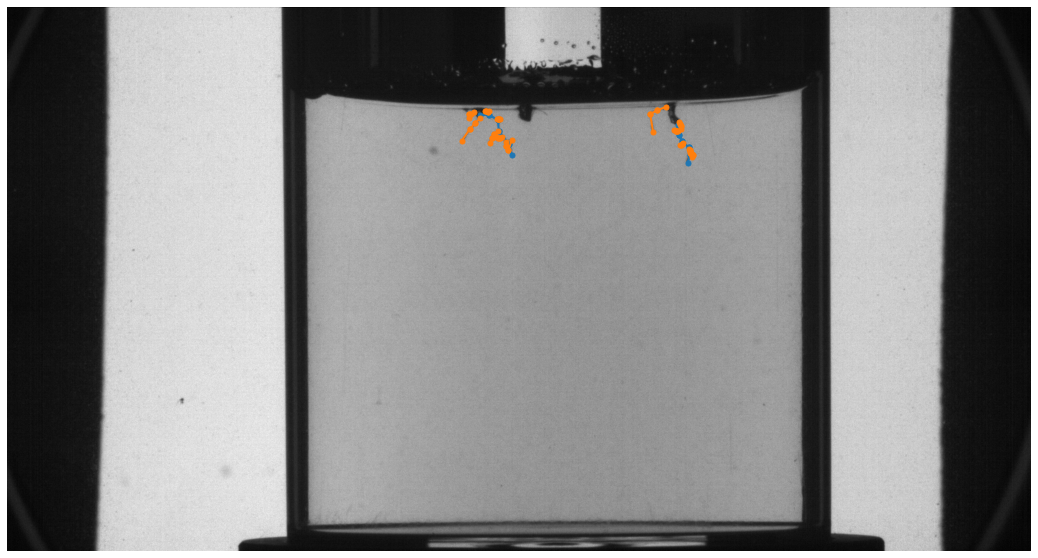

In [11]:
# Plot the first frame of the first series
series.plot(0, scale=0.5)

In [12]:
# Get the primary root points for the first frame
primary_pts = series.get_primary_points(0)
print(f"Shape of primary points: {primary_pts.shape}")

# Get the lateral root points for the first frame
lateral_pts = series.get_lateral_points(0)
print(f"Shape of lateral points: {lateral_pts.shape}")

Shape of primary points: (2, 6, 2)
Shape of lateral points: (13, 4, 2)


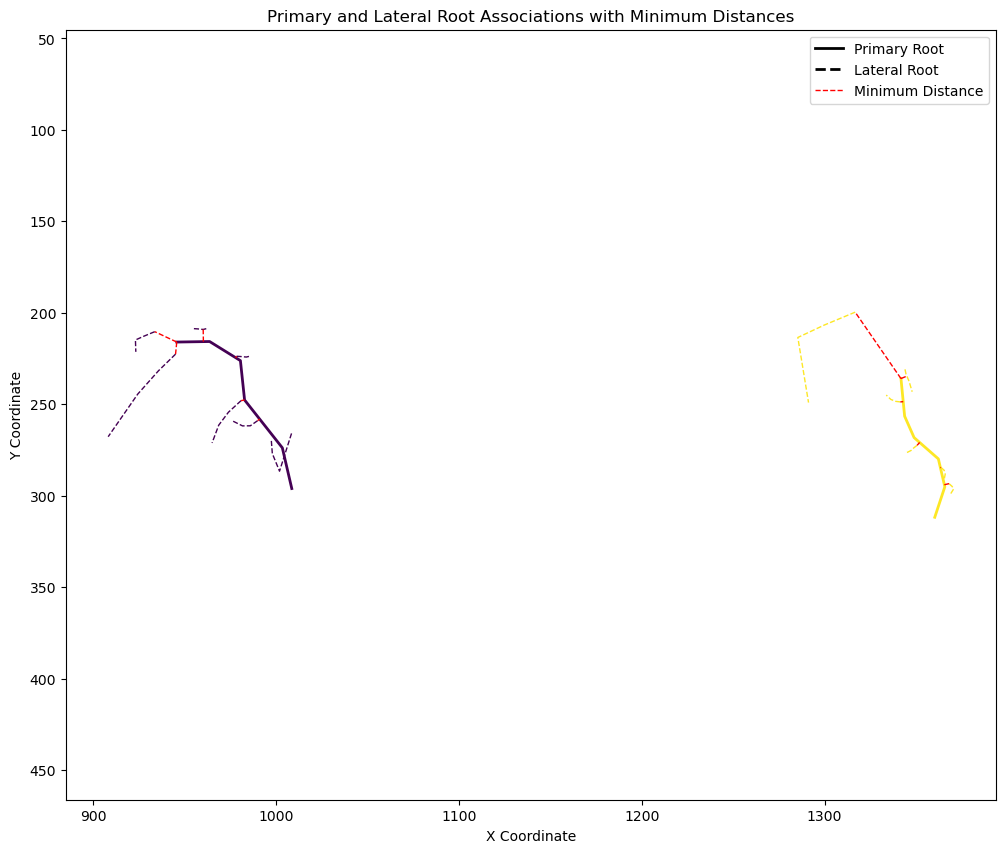

In [13]:
# Associate lateral roots to primary roots
plant_dict = associate_lateral_to_primary(primary_pts, lateral_pts)

# Plot the plants (associated primary and lateral roots)
plot_root_associations(plant_dict)

Use the `MultipleDicotPipeline` for computing all of the traits of all of the samples

In [14]:
# Initialize the pipeline for multiple dicots
pipeline = sr.MultipleDicotPipeline()

In [15]:
# Get the traits of the first sample
first_sample_traits = pipeline.compute_multiple_dicots_traits(series=series, write_json=True, write_csv=True)

Aggregated traits saved to 6039_1.all_frames_traits.json
Summary statistics saved to 6039_1.all_frames_summary.csv


<Axes: ylabel='Count'>

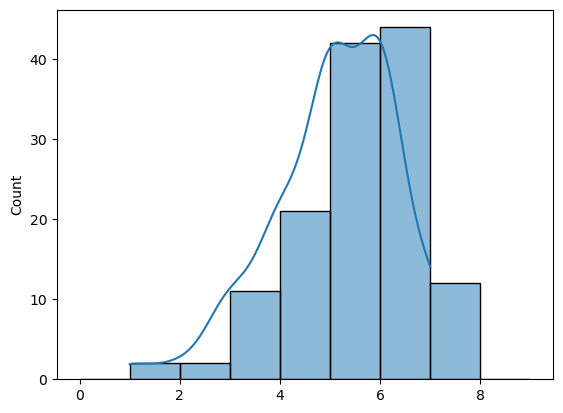

In [16]:
# Make a histogram of the lateral root count for the first sample
lateral_ct = first_sample_traits["traits"]["lateral_count"]
sns.histplot(lateral_ct, bins=range(0, 10), kde=True)

In [17]:
# Get the traits for all samples, grouped by genotype
# Samples with qc_fail=1 are excluded
grouped_traits = pipeline.compute_multiple_dicots_traits_for_groups(series_list=list(all_series), output_dir="grouped_traits_after_qc", write_json=True, write_csv=True)

Skipping series '6039_1' due to qc_fail flag.
Processing series '7327_2'
Finished processing group '7327'
Aggregated traits for group 7327 saved to grouped_traits_after_qc\7327.grouped_traits.json
Summary statistics for group 7327 saved to grouped_traits_after_qc\7327.grouped_summary.csv
Processing series '9535_1'
Finished processing group '9535'
Aggregated traits for group 9535 saved to grouped_traits_after_qc\9535.grouped_traits.json
Summary statistics for group 9535 saved to grouped_traits_after_qc\9535.grouped_summary.csv
Processing series '997_1'
Finished processing group '997'
Aggregated traits for group 997 saved to grouped_traits_after_qc\997.grouped_traits.json
Summary statistics for group 997 saved to grouped_traits_after_qc\997.grouped_summary.csv


In [18]:
# Get the summary statistics of the traits for all samples, grouped by genotype
grouped_summary_df = pipeline.compute_batch_multiple_dicots_traits_for_groups(all_series=list(all_series), output_dir="grouped_traits_after_qc", write_json=True, write_csv=True)

Skipping series '6039_1' due to qc_fail flag.
Processing series '7327_2'
Finished processing group '7327'
Aggregated traits for group 7327 saved to grouped_traits_after_qc\7327.grouped_traits.json
Processing series '9535_1'
Finished processing group '9535'
Aggregated traits for group 9535 saved to grouped_traits_after_qc\9535.grouped_traits.json
Processing series '997_1'
Finished processing group '997'
Aggregated traits for group 997 saved to grouped_traits_after_qc\997.grouped_traits.json
Computed traits for all groups saved to group_summarized_traits.csv


In [19]:
# Inspect the summary statistics
grouped_summary_df

,genotype,lateral_count_min,lateral_count_max,lateral_count_mean,lateral_count_median,lateral_count_std,lateral_count_p5,lateral_count_p25,lateral_count_p75,lateral_count_p95,...,network_distribution_ratio_p95,network_solidity_min,network_solidity_max,network_solidity_mean,network_solidity_median,network_solidity_std,network_solidity_p5,network_solidity_p25,network_solidity_p75,network_solidity_p95
0,7327,1,9,3.434109,1.0,2.825260,1.00,1.0,6.00,8.0,...,0.679840,0.024168,0.293489,0.092920,0.087395,0.062009,0.030521,0.041196,0.125539,0.214581
1,9535,1,12,5.428571,6.0,3.579990,1.00,1.0,6.00,12.0,...,0.680365,0.037658,0.238548,0.074350,0.063223,0.041686,0.043457,0.050439,0.079101,0.121559
2,997,4,9,7.000000,7.5,1.914854,4.25,5.5,8.75,9.0,...,0.550392,0.017635,0.028867,0.021103,0.019285,0.004037,0.017699,0.017987,0.022816,0.027564
